# Image Classification Lung Disease

## Download and import required libraries 

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

In [2]:
!pip install scipy

In [3]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2, os, sys

import random

import os
from shutil import copyfile
import shutil

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers

In [4]:
import zipfile

In [5]:
!pip install kaggle

In [6]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.6.0


## GPU Information

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
!nvidia-smi

Mon Oct  7 15:50:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   45C    P5             N/A /  115W |    7758MiB /   8188MiB |     44%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
# Configure GPU
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Import

In [10]:
!kaggle datasets download -d omkarmanohardalvi/lungs-disease-dataset-4-types

Dataset URL: https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types
License(s): unknown
lungs-disease-dataset-4-types.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
with zipfile.ZipFile('lungs-disease-dataset-4-types.zip','r') as zip_ref:
    zip_ref.extractall()

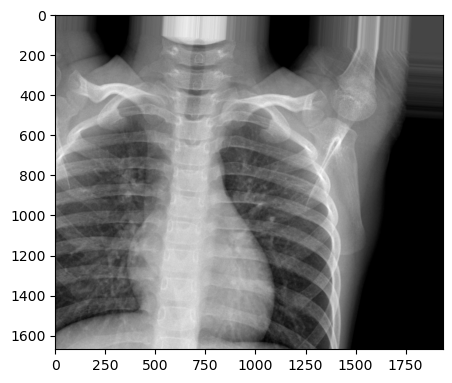

In [12]:
# simply show a picture
plt.figure(figsize= (5, 5))
img = mpimg.imread("Lung Disease Dataset/train/Normal/test_0_9774.jpeg")
plt.imshow(img)
plt.show()

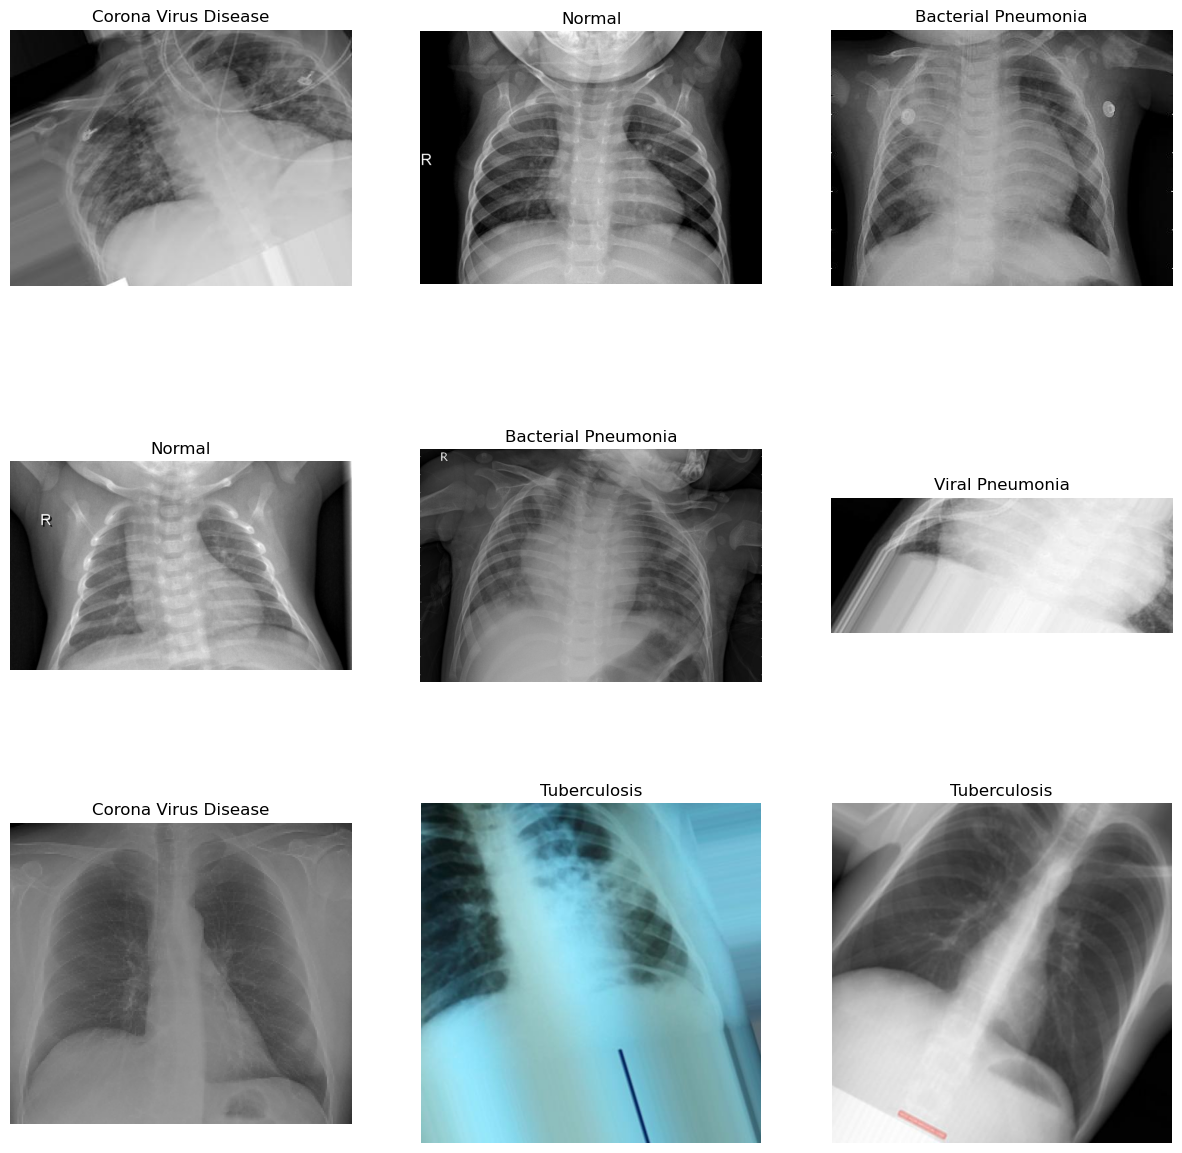

In [13]:
# Function to load images from a directory and its subdirectories
def load_images_from_folder(folder, num_images_per_class):
    images = []
    labels = []
    for subdir, _, files in os.walk(folder):
        if os.path.basename(subdir).startswith('.'):  # Skip hidden directories
            continue
        label = os.path.basename(subdir)
        class_images = []
        for filename in files:
            if filename.startswith('.'):  # Skip hidden files
                continue
            filepath = os.path.join(subdir, filename)
            if not os.path.isdir(filepath) and filename.endswith(('.jpg', '.jpeg', '.png')):  # Only read image files
                try:
                    img = cv2.imread(filepath)  # Read the image using OpenCV
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    if img is not None:
                        class_images.append(img)
                except Exception as e:
                    print(f"Error loading {filepath}: {e}")
        random.shuffle(class_images)  # Shuffle the images of the class
        images.extend(class_images[:num_images_per_class])
        labels.extend([label] * min(num_images_per_class, len(class_images)))
    return images, labels

# Directory containing the images
image_dir = "Lung Disease Dataset/train/"

# Number of images to display per class
num_images_per_class = 3  # Change this to the desired number of images per class

# Load images
images, labels = load_images_from_folder(image_dir, num_images_per_class)

# Randomly shuffle the images and labels together
combined = list(zip(images, labels))
random.shuffle(combined)
images[:], labels[:] = zip(*combined)

# Limit to 9 images for the 3x3 grid
images = images[:9]
labels = labels[:9]

# Display images in a grid
plt.figure(figsize=(15, 15))
columns = 3
for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(3, 3, i + 1)  # Fixed to a 3x3 grid
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [14]:
import os
print(len(os.listdir("Lung Disease Dataset/train/Tuberculosis")))

1220


In [15]:
def plot_num_images_per_class(dataset_dir, dataset_type, classes, colors):
    """
    Plots the number of images per class in the specified dataset.

    Parameters:
    dataset_dir (str): Path to the dataset directory.
    dataset_type (str): Type of the dataset ('train', 'validation', 'test').
    classes (list): List of class names.
    colors (list): List of colors for each class.
    """
    # Construct the path to the dataset type directory
    dataset_type_dir = os.path.join(dataset_dir, dataset_type)

    # Count the number of images for each class
    num_images_per_class = []
    for cls in classes:
        class_dir = os.path.join(dataset_type_dir, cls)
        num_images = len(os.listdir(class_dir))
        num_images_per_class.append(num_images)

    # Plot the bar chart with text labels
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, num_images_per_class, color=colors)

    # Add text labels to each bar
    for bar, num_images in zip(bars, num_images_per_class):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, num_images, ha='center', va='bottom')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images per Class in {dataset_type.capitalize()} Dataset')
    plt.xticks(rotation=0)  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

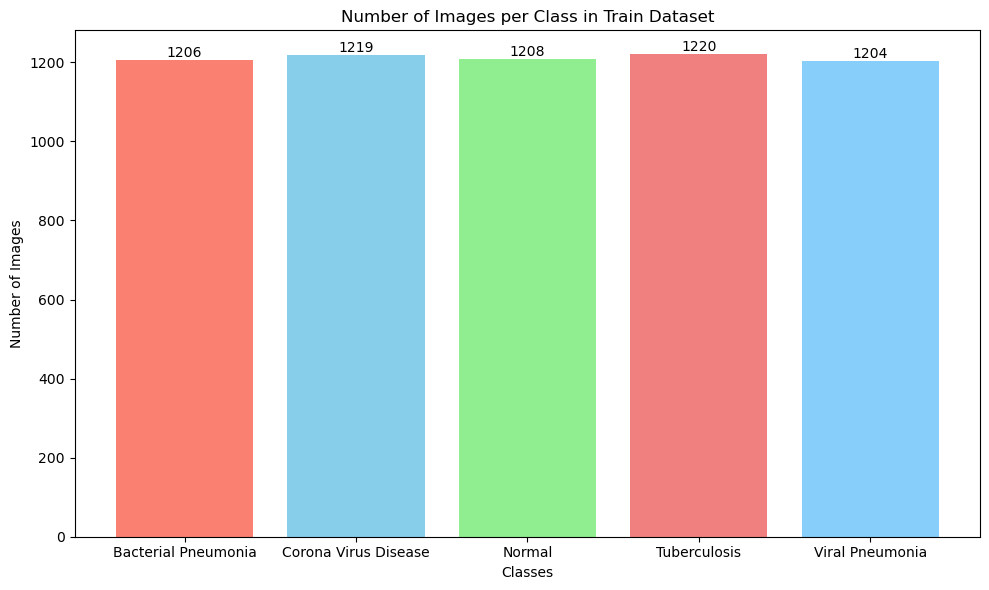

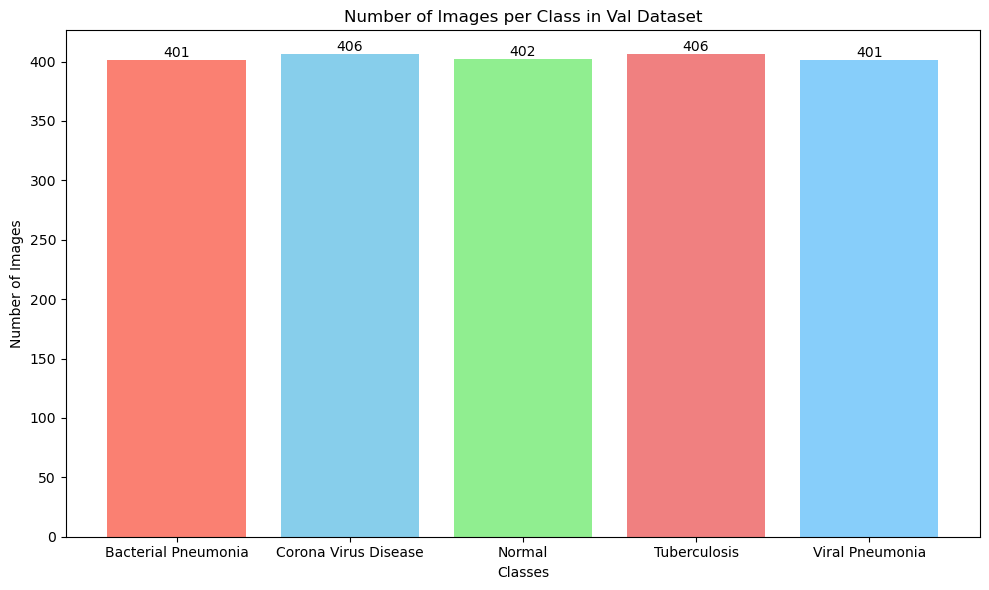

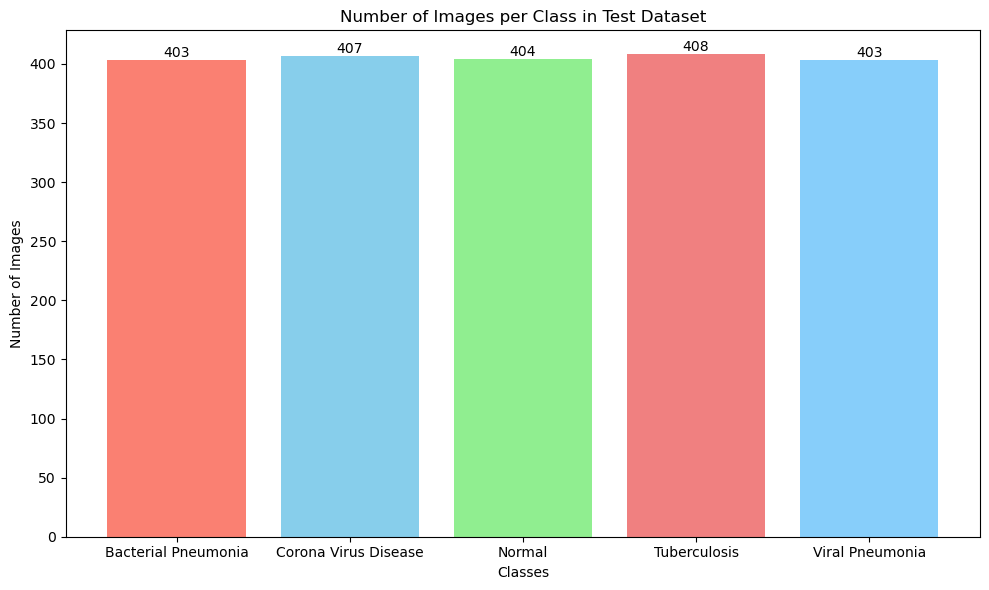

In [16]:
# Define the path to the dataset directory
dataset_dir = "Lung Disease Dataset"

# Define a list of classes
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]

# Define colors for each class
colors = ['salmon', 'skyblue', 'lightgreen', 'lightcoral', 'lightskyblue']

# Plot number of images for training, validation, and test datasets
plot_num_images_per_class(dataset_dir, 'train', classes, colors)
plot_num_images_per_class(dataset_dir, 'val', classes, colors)
plot_num_images_per_class(dataset_dir, 'test', classes, colors)

## Data Preparation

In [17]:
def dataset_mini(src, dest, sample_size=200):
    # Check if the destination directory exists
    if os.path.exists(dest):
        # If it exists, remove it to ensure a clean slate
        shutil.rmtree(dest)  # Removing dataset_mini (if it already exists) folders
    # Create the destination directory
    os.makedirs(dest)

    # Iterate over each directory in the source directory
    for food_item in os.listdir(src):
        if not food_item.startswith('.'):  # Skip hidden directories
            if os.path.isdir(os.path.join(src, food_item)):
                print("Copying images into", food_item)
                # Create a directory for the current food item in the destination directory
                os.makedirs(os.path.join(dest, food_item))
                # Get a list of all the files in the source directory for the current food item
                files = os.listdir(os.path.join(src, food_item))
                # Copy only the first `sample_size` files from the source directory to the destination directory
                for file in files[:sample_size]:
                    src_file = os.path.join(src, food_item, file)
                    dst_file = os.path.join(dest, food_item, file)
                    if not os.path.isdir(src_file):  # Skip directories
                        shutil.copyfile(src_file, dst_file)

# Example usage:
train_src_dir = "Lung Disease Dataset/train/"
train_dest_dir = "train_mini"
test_src_dir = "Lung Disease Dataset/test/"
test_dest_dir = "test_mini"
val_src_dir = "Lung Disease Dataset/val/"
val_dest_dir = "val_mini"
dataset_mini(train_src_dir, train_dest_dir, sample_size=1200)
dataset_mini(test_src_dir, test_dest_dir, sample_size=200)
dataset_mini(val_src_dir, val_dest_dir, sample_size=200)

Copying images into Bacterial Pneumonia
Copying images into Corona Virus Disease
Copying images into Normal
Copying images into Tuberculosis
Copying images into Viral Pneumonia
Copying images into Bacterial Pneumonia
Copying images into Corona Virus Disease
Copying images into Normal
Copying images into Tuberculosis
Copying images into Viral Pneumonia
Copying images into Bacterial Pneumonia
Copying images into Corona Virus Disease
Copying images into Normal
Copying images into Tuberculosis
Copying images into Viral Pneumonia


## Data Augmentation

In [18]:
# ImageDataGenerator (only can adjust on training data)
traingen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.1 , # add
    height_shift_range=0.1 , # add
  )
valgen = ImageDataGenerator(rescale= 1./255)
testgen = ImageDataGenerator(rescale= 1./255)

In [19]:
# flow_from_directory
train_it = traingen.flow_from_directory(
    "train_mini",
    target_size = (224, 224),
)
val_it = valgen.flow_from_directory(
    "val_mini",
    target_size = (224, 224),
)
test_it = testgen.flow_from_directory(
    "test_mini",
    target_size = (224, 224),
    shuffle = False,
)

Found 5997 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [20]:
import pathlib
data_dir = pathlib.Path(train_src_dir)
# Sorted in alphabetic order
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(data_dir)
print(class_names)
print(f"Total number of classes: {len(class_names)}")

Lung Disease Dataset\train
['Bacterial Pneumonia' 'Corona Virus Disease' 'Normal' 'Tuberculosis'
 'Viral Pneumonia']
Total number of classes: 5


In [21]:
import scipy


## Development and training of model

In [22]:
# Load the DenseNet201 model pre-trained on ImageNet data
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the DenseNet201 base
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(base_model.input, output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint("densenetCB.h5", monitor="val_accuracy", save_best_only=True, mode="max")

# Train the model
history = model.fit(
    train_it,
    epochs=80,
    validation_data=val_it,
    steps_per_epoch=15,
    callbacks=[checkpoint]
)


Epoch 1/80
15/15 [==============================] - 35s 1s/step - loss: 27.0866 - accuracy: 0.4292 - val_loss: 2.1376 - val_accuracy: 0.6750
Epoch 2/80
15/15 [==============================] - 14s 937ms/step - loss: 1.3549 - accuracy: 0.6729 - val_loss: 0.5821 - val_accuracy: 0.8250
Epoch 3/80
15/15 [==============================] - 14s 937ms/step - loss: 0.7337 - accuracy: 0.7604 - val_loss: 0.4400 - val_accuracy: 0.8410
Epoch 4/80
15/15 [==============================] - 14s 946ms/step - loss: 0.6241 - accuracy: 0.7604 - val_loss: 0.6871 - val_accuracy: 0.7220
Epoch 5/80
15/15 [==============================] - 13s 923ms/step - loss: 0.6541 - accuracy: 0.7688 - val_loss: 0.4086 - val_accuracy: 0.8520
Epoch 6/80
15/15 [==============================] - 14s 921ms/step - loss: 0.5357 - accuracy: 0.8167 - val_loss: 0.4191 - val_accuracy: 0.8390
Epoch 7/80
15/15 [==============================] - 13s 920ms/step - loss: 0.5193 - accuracy: 0.8000 - val_loss: 0.3502 - val_accuracy: 0.8710
E

In [23]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

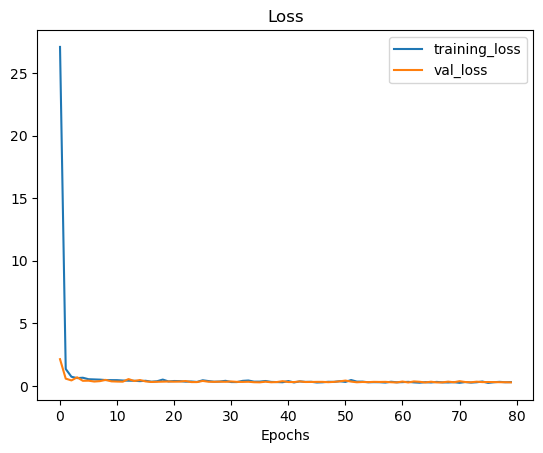

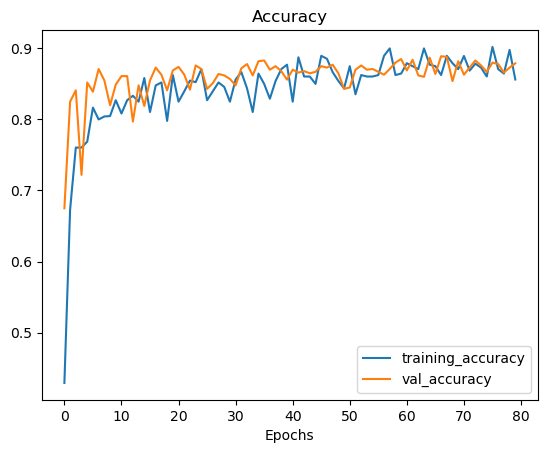

In [24]:
plot_loss_curves(history)

## Testing and evaluation of Model

In [25]:
results = model.evaluate(test_it)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

32/32 [==============================] - 10s 319ms/step - loss: 0.3090 - accuracy: 0.8730
Test Loss: 0.3089931905269623
Test Accuracy: 0.8730000257492065


In [26]:
print(test_it.class_indices)

{'Bacterial Pneumonia': 0, 'Corona Virus Disease': 1, 'Normal': 2, 'Tuberculosis': 3, 'Viral Pneumonia': 4}


## Confusion Matrix

true_labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 

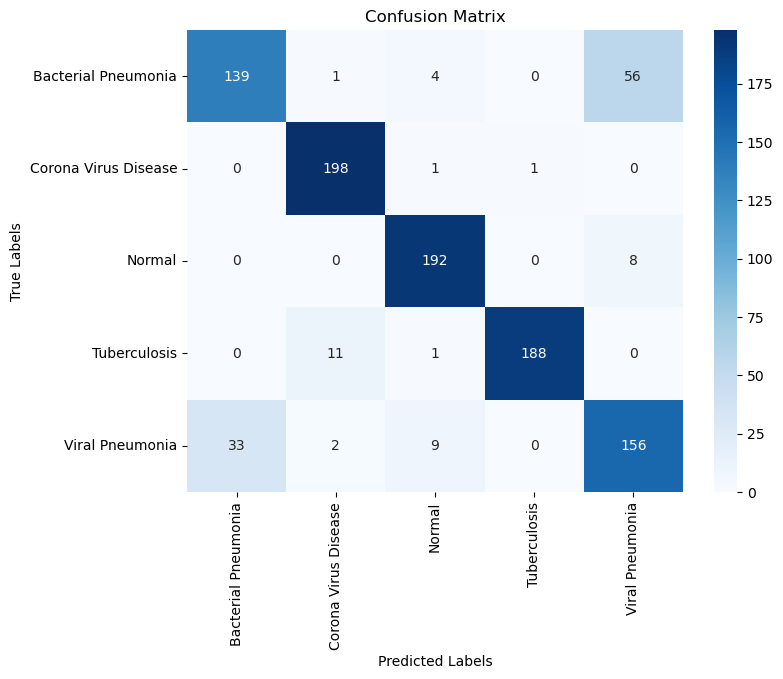

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Get the true labels
true_labels = test_it.classes
print("true_labels: ",true_labels)

# Predict the labels using the model
predictions = model.predict(test_it)
print("Prediction: ", predictions)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)
print("Predicted_labels", predicted_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_it.class_indices, yticklabels=test_it.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
from sklearn.metrics import classification_report

# Get the true labels from the test iterator
y_true = test_it.classes  # Assuming `test_it` has a `.classes` attribute for true labels.

# Get class labels from the test iterator if needed
class_labels = list(test_it.class_indices.keys())

# Predict probabilities on the test set
y_pred_probs = model.predict(test_it)

# Convert probabilities to class labels (index with the highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print the classification report with averages rounded to 3 decimal places
print(classification_report(y_true, y_pred, target_names=class_labels, digits=3))


                      precision    recall  f1-score   support

 Bacterial Pneumonia      0.808     0.695     0.747       200
Corona Virus Disease      0.934     0.990     0.961       200
              Normal      0.928     0.960     0.943       200
        Tuberculosis      0.995     0.940     0.967       200
     Viral Pneumonia      0.709     0.780     0.743       200

            accuracy                          0.873      1000
           macro avg      0.875     0.873     0.872      1000
        weighted avg      0.875     0.873     0.872      1000



## Saving model

In [29]:
# model.save("testing.h5")

In [30]:
# from keras.models import load_model
# xray_model = load_model("testing.h5")
# model = load_model("testing.h5")
# print(xray_model.summary())

## Heat Map Image

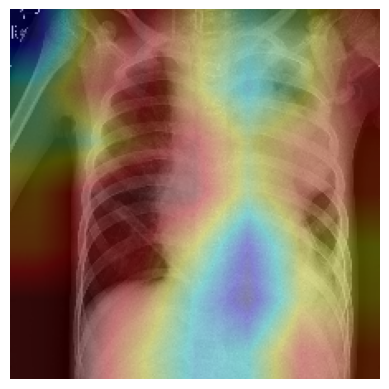

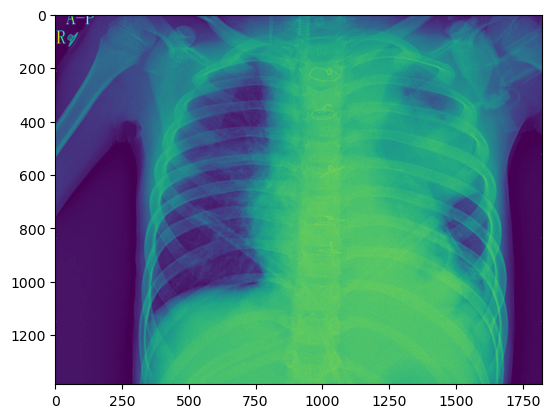

In [31]:
from tensorflow.keras.applications.densenet import preprocess_input

# def preprocess_input_densenet(img):
#     # Convert pixel values to range [0, 1]
#     img = img.astype(np.float32) / 255.0
#     # Apply per-channel mean normalization
#     img[:, :, 0] = (img[:, :, 0] - 0.5) / 0.5
#     img[:, :, 1] = (img[:, :, 1] - 0.5) / 0.5
#     img[:, :, 2] = (img[:, :, 2] - 0.5) / 0.5
#     return img

def get_heatmap(model, image_path, intensity=0.5):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = np.expand_dims(img, axis=0)
    
    # Preprocess the image
    img_array = preprocess_input(img_array)
    
    # Get the class activation heatmap
    last_conv_layer = model.get_layer("conv5_block32_concat")
    heatmap_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = heatmap_model(img_array)
        class_out = predictions[:, np.argmax(predictions[0])]
        grads = tape.gradient(class_out, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Resize heatmap to the size of the original image
    heatmap = cv2.resize(heatmap[0], (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    # Apply heatmap on the original image with adjusted intensity
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_with_image = cv2.addWeighted(img, 1-intensity, heatmap, intensity, 0)
    
    return heatmap_with_image

# Get a sample X-ray image path
# image_path = "xrayimg.png"
image_path = "Lung Disease Dataset/test/Bacterial Pneumonia/BACTERIA-9012339-0002.jpeg"
# Get the heatmap for the image
heatmap_image = get_heatmap(model, image_path, intensity=0.3)
# Display the heatmap with the original image
plt.imshow(heatmap_image)
plt.axis('off')
plt.show()


# simply show a picture
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()
